# Defensive Perception: Estimation and Monitoring of Neural Network Performance under Deployment

In this paper, we propose a method for addressing the issue of unnoticed catastrophic deployment and domain shift in neural networks for semantic segmentation in autonomous driving. Our approach is based on the idea that deep learning-based perception for autonomous driving is uncertain and best represented as a probability distribution. As autonomous vehicles' safety is paramount, it is crucial for perception systems to recognize when the vehicle is leaving its operational design domain, anticipate hazardous uncertainty, and reduce the performance of the perception system. To address this, we propose to encapsulate the neural network under deployment within an uncertainty estimation envelope that is based on the epistemic uncertainty estimation through the Monte Carlo Dropout approach. This approach does not require modification of the deployed neural network and guarantees expected model performance. Our defensive perception envelope has the capability to estimate a neural network's performance, enabling monitoring and notification of entering domains of reduced neural network performance under deployment. Furthermore, our envelope is extended by novel methods to improve the application in deployment settings, including reducing compute expenses and estimation noise. Finally, we demonstrate the applicability of our method for multiple different potential deployment shifts relevant to autonomous driving, such as transitions into the night, rainy, or snowy domain. Overall, our approach shows great potential for application in deployment settings and enables operational design domain recognition via uncertainty, which allows for defensive perception, safe state triggers, warning notifications, and feedback for testing or development and adaptation of the perception stack.

## Defensive Perception Sandbox

In [10]:
!pip install tensorflow==2.8.0;
!pip install keras==2.8.0;
!pip install matplotlib;
!pip install scipy;

In [2]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from scipy import ndimage

### The Data

In this study, we conduct experiments using two datasets: the MNIST dataset and the BDD10K dataset. The MNIST dataset, which represents a relatively simple
machine learning task, is used to provide a general proof of concept for the proposed metric. The BDD10K dataset, which is trained on a segmentation model and represents a more complex task, serves as a real-world example in the
context of autonomous driving.

MNIST [13] consists of 70,000 handwritten numbers containing the digits zero through nine and accordingly labeled, suitable for a classification task. MNIST is deployed as a toy problem, being well-known, easy to interpret, and
comprehensible.

In the first experiment, we introduce a domain shift to the MNIST dataset by anticlockwise rotating the given samples in five-degree increments up to a total of 90 degrees.

Rotations Finished: 19/19
Done


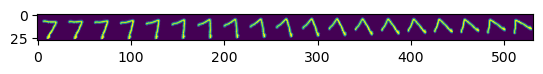

In [9]:
# Prepare the Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Convert the labels to one hot labels
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

# The Rotations on which the model is tested later is defined here
ROTATIONS = [rot for rot in np.arange(0, 91, 5)]

# List that stores the Datasets for each rotation
rotated_testset = []

# Rotate the actual images and store them
for i, rotation in enumerate(ROTATIONS):
    x_test_rotated = ndimage.rotate(x_test, rotation, reshape=False, axes=(1, 2))
    rotated_testset.append([x_test_rotated, y_test])
    print("\rRotations Finished: {}/{}".format(i+1, len(ROTATIONS)), end="")

print("\nDone")

# Check one Sample in the rotated data
check_rotations = np.concatenate([img[0][0] for img in rotated_testset], axis=1)
plt.imshow(check_rotations)
plt.show()


### Training a Model for Deployment

The classifier, which is only trained on the source domain (non-rotated samples), is equipped with dropout layers.

The model for this experiment is only trained on a defined source domain: This is non-rotated numbers. Any data that is not part of the source domain is framed and subsequently interpreted as a domain shift. This data is then only used at inference time for validation and test purposes

In [4]:
# Train the Model
from keras.layers import *
from keras.models import *
from tensorflow.keras.optimizers import Adam


def MNIST_Model(shape=(28, 28, 1), training_var=True, dropout=0.2):
    """ MNIST-Model
    Keras model build like described in "Cuepervision: Self-supervised learning for continuous domain adaptation
    without catastrophic forgetting
    
    Args:
        shape: Shape of the model input
        training_var: Set this to True when using dropout
        dropout: Percent of connections to drop
    
    """
    input_layer = Input(shape=shape)
    flatten_layer = Flatten()(input_layer)
    fully_connected_relu = Dense(512, activation="relu")(flatten_layer)
    dropout = Dropout(dropout)(fully_connected_relu, training=training_var)
    output_dense_layer = Dense(10, activation="softmax")(dropout)
    model = Model(inputs=input_layer, outputs=output_dense_layer)

    model.compile(
        optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model


BATCH_SIZE = 500
STEPS_PER_EPOCH = int(len(x_train) / BATCH_SIZE)
EPOCHS = 100


model = MNIST_Model(dropout=0.5)

history = model.fit(
    x=x_train, 
    y=y_train, 
    validation_data = [x_test, y_test],
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    verbose=1
)

model.save_weights("./Models/MNIST")

del model

Epoch 1/100
120/120 [==============================] - 3s 17ms/step - loss: 9.6872 - accuracy: 0.8166 - val_loss: 1.3267 - val_accuracy: 0.8342
Epoch 2/100
120/120 [==============================] - 2s 14ms/step - loss: 0.9727 - accuracy: 0.8455 - val_loss: 0.8277 - val_accuracy: 0.8420
Epoch 3/100
120/120 [==============================] - 2s 16ms/step - loss: 0.6468 - accuracy: 0.8657 - val_loss: 0.6652 - val_accuracy: 0.8648
Epoch 4/100
120/120 [==============================] - 2s 15ms/step - loss: 0.4903 - accuracy: 0.8904 - val_loss: 0.5836 - val_accuracy: 0.8812
Epoch 5/100
120/120 [==============================] - 2s 15ms/step - loss: 0.4082 - accuracy: 0.9021 - val_loss: 0.5412 - val_accuracy: 0.8921
Epoch 6/100
120/120 [==============================] - 2s 14ms/step - loss: 0.3533 - accuracy: 0.9118 - val_loss: 0.4969 - val_accuracy: 0.9021
Epoch 7/100
120/120 [==============================] - 2s 13ms/step - loss: 0.3115 - accuracy: 0.9202 - val_loss: 0.4467 - val_accuracy:

120/120 [==============================] - 2s 13ms/step - loss: 0.1485 - accuracy: 0.9646 - val_loss: 0.3195 - val_accuracy: 0.9483
Epoch 58/100
120/120 [==============================] - 2s 16ms/step - loss: 0.1369 - accuracy: 0.9655 - val_loss: 0.3235 - val_accuracy: 0.9507
Epoch 59/100
120/120 [==============================] - 2s 13ms/step - loss: 0.1335 - accuracy: 0.9658 - val_loss: 0.3261 - val_accuracy: 0.9474
Epoch 60/100
120/120 [==============================] - 1s 12ms/step - loss: 0.1338 - accuracy: 0.9667 - val_loss: 0.3161 - val_accuracy: 0.9498
Epoch 61/100
120/120 [==============================] - 2s 14ms/step - loss: 0.1448 - accuracy: 0.9655 - val_loss: 0.3234 - val_accuracy: 0.9500
Epoch 62/100
120/120 [==============================] - 1s 12ms/step - loss: 0.1384 - accuracy: 0.9655 - val_loss: 0.3493 - val_accuracy: 0.9500
Epoch 63/100
120/120 [==============================] - 1s 11ms/step - loss: 0.1410 - accuracy: 0.9659 - val_loss: 0.3706 - val_accuracy: 0.953

## Defensive Perception Envelope

In the following, we present a detailed overview of our proposed method for estimating uncertainty and monitoring the performance of neural networks during deployment. Our approach utilizes a defensive perception envelope, which is wrapped around a given perception algorithm. Typically, the performance of a neural network is evaluated by comparing its predictions to manually labeled data (ground truth). However, such labeled data is unavailable during online inference in autonomous driving. To address this, our defensive perception envelope indirectly estimates the neural network’s performance using Monte Carlo Dropout, enabling real-time performance estimation during deployment:

<img src="UncertaintyFramework.png" width="454" align="center">

The Figure above illustrates the schematic of our
proposed framework.



### Pseudo Cross-Entropy for Uncertainty during Inference
To measure the uncertainty over multiple forward passes, the one-hot encoded output vector $\textbf{y}_{fwp}$ from each forward pass ($fwp$) is taken, and the hits for each class are accumulated. 
The retrieved vector $\textbf{v}_{hC}$ shows the distribution of hits over all classes for the number of applied forward passes. As only the classes, which are predicted in at least one of the forward passes, are of interest, any class with $0$ hits is removed from this vector so that  $\textbf{v}_{hC} \setminus \{0\}$.

From this vector, the class with the maximum number of hits is assumed to be the true class, hence a pseudo ground truth $max(\textbf{v}_{hC})$ is determined. 
As only the classes $i$ with at least one hit in any of the forward passes are of interest, these classes are represented by $\mathcal{C}_h$. 

The here presented formula fulfilling the requirements mentioned above is:

\begin{align}
    CE_u = 1-\frac{exp({\frac{max(\textbf{v}_{hC})}{n_{fwp}}})}{\sum_{i}^{C_h} exp({\frac{\textbf{v}_{hC}(i)}{n_{fwp}}})}
    % This metric doesn't reach one, and has an exponential increase
\end{align}

For intuitive readability, the uncertainty measurement is subtracted from one to have a low score near zero when the uncertainty of the neural network is low and a value near one when the uncertainty is critical.

In [5]:
def categorical_crossentropy_metric_single(result_vector):
    n_classes = len(result_vector)
    fwp = sum(result_vector)
    hit_vector = result_vector

    while 0 in hit_vector:
        hit_vector.remove(0)

    denominator = 0
    
    hit_vector = [element / float(fwp) for element in hit_vector] 

    for element in hit_vector:
        denominator += np.exp(element)
    #    
    val = 1-(np.exp(max(hit_vector)) / denominator)

    
    return val



def categorical_crossentropy_metric(result_vector: np.array, n_categories: int):    
    m_carlo = []
    fwp = result_vector.shape[0]

    for pos in range(len(result_vector[0])):
        # One pass for every predicted image in values parameter
        values_counted = [0] * n_categories
        for v in range(n_categories):
            values_counted[v] = np.count_nonzero(result_vector[:, pos] == v)

        m_carlo.append(categorical_crossentropy_metric_single(values_counted))

    return m_carlo

The
uncertainty of each domain is calculated using Monte Carlo Dropout on 20 forward passes for each sample. Since the labels and correct class for the
out-of-domain samples are available, we compare the uncertainty and performance estimation to the prediction error and model confidence derived from the maximum one-hot encoded output vector of the model’s prediction.

In [6]:
n_fwp = 20
dropout_value = 0.4

errors = []
mcd = []
max_one_hot = []

# Load two seperate Models. One with dropout and one without
model_without_dropout = MNIST_Model(training_var=False)
model_without_dropout.load_weights("./Models/MNIST").expect_partial()
model_with_dropout = MNIST_Model(dropout=dropout_value)
model_with_dropout.load_weights("./Models/MNIST").expect_partial()

print("\r Process: {}/{}".format(0, len(rotated_testset)), end="")

for i, (x_rotated, y_rotated) in enumerate(rotated_testset):
    predictions = []
    for _ in range(n_fwp):
        prediction = model_with_dropout.predict(x_rotated)
        prediction = tf.argmax(prediction, -1)
        predictions.append(prediction)
    # m_carlo = hit_distribution_metric(np.array(predictions), 10)
    m_carlo = categorical_crossentropy_metric(np.array(predictions), 10)
    mcd.append(m_carlo)
    
    _, acc = model_without_dropout.evaluate(x_rotated, y_rotated, verbose=0)
    max_one_hot.append(np.sum(np.max(model_without_dropout.predict(x_rotated), axis=-1))/len(x_rotated))
    error = 1 - acc
    errors.append(error)
    print("\r Process: {}/{}".format(i+1, len(rotated_testset)), end="")

 Process: 19/19

### Visualizing the Results

In [7]:
from typing import List
import matplotlib.patches as mpatches

def plot_mcd_results(
    indices: List,
    monte_carlo_dropout: List,
    error: List,
    max_one_hot: List,
    title: str,
    x_label: str,
):
    """Plots the results of the mcd calculations

    Args:
        indices: List of indices
        monte_carlo_dropout: list of monte carlo dropouts
        error: List of errors
        title: Title that is displayed above the matplotlib plot
        x_label: Description of the x-Axis
    """    
    acc_all = error
    
    x_labels = indices

    monte_carlo = monte_carlo_dropout
    
    for param in ["figure.facecolor", "axes.facecolor", "savefig.facecolor"]:
        plt.rcParams[param] = "#FFFFFF"

    for param in [
        "text.color",
        "axes.labelcolor",
        "xtick.color",
        "ytick.color",
    ]:
        plt.rcParams[param] = "0.0"

    figure = plt.figure(figsize=(25 * 1 / 2.54, 15 * 1 / 2.54))

    ax1 = figure.add_subplot(1, 1, 1)
    ax1.grid(color="#EEEEEE", axis="y")
    c = "#FF5500"
    red_dict = {
        "patch_artist": False,
        "boxprops": dict(color="#000000"),  # , facecolor=None),
        "capprops": dict(color="#000000"),
        "flierprops": dict(color="#000000", markeredgecolor="#000000"),
        "medianprops": dict(color=c, linewidth=4),
        "whiskerprops": dict(color="#000000"),
    }

    x_ticks = []
    pos = [h for h in range(len(indices))]
    ax1.boxplot(monte_carlo, positions=pos, labels=["asdf"] + ["asdf" for _ in range(len(indices)-1)], showmeans=True, **red_dict)  # , widths=3)
    
    x_ticks += pos

    ax1.plot(
        [h for h in range(len(indices))],
        acc_all,
        "o",
        label="error",
        color="#009682",
    )
    
    ax1.plot(
        [h for h in range(len(indices))],
        max_one_hot,
        "o",
        label="max one-hot",
        color="#00ABE7",
    )
        
    ax1.xaxis.grid(False)
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_labels)
    ax1.set_title(title, fontsize=20.0)
    ax1.set_ylim(-0.05, 1.05)
    ax1.set_ylabel("error / uncertainty", fontsize=15.0)
    ax1.set_xlabel(x_label, fontsize=15.0)
    
    handles, labels = ax1.get_legend_handles_labels()
    orange_patch = mpatches.Patch(color='#FF5500', label='uncertainty')
    green_box = mpatches.Arrow(0, 0, 1, 1, width=1, color="#55CC55", label='mean uncertainty')
    handles.append(orange_patch) 
    handles.append(green_box) 
    ax1.legend(handles=handles, loc="upper right")

    plt.tight_layout()
    plt.plot()

### Prediction Confidence is a Lie

Both the error and uncertainty increase with the rotation. It is worth noting that even though the model’s performance on the out-of-domain data drops by over 90%, its confidence merely drops by 14%. This behavior is substantiated by Spearman’s rank correlation coefficients [19]. While the uncertainty and the
model error have a correlation coefficient of 0.93, the correlation coefficient of the maximum one hot encoded values with respect to the error is nine percentage points lower.

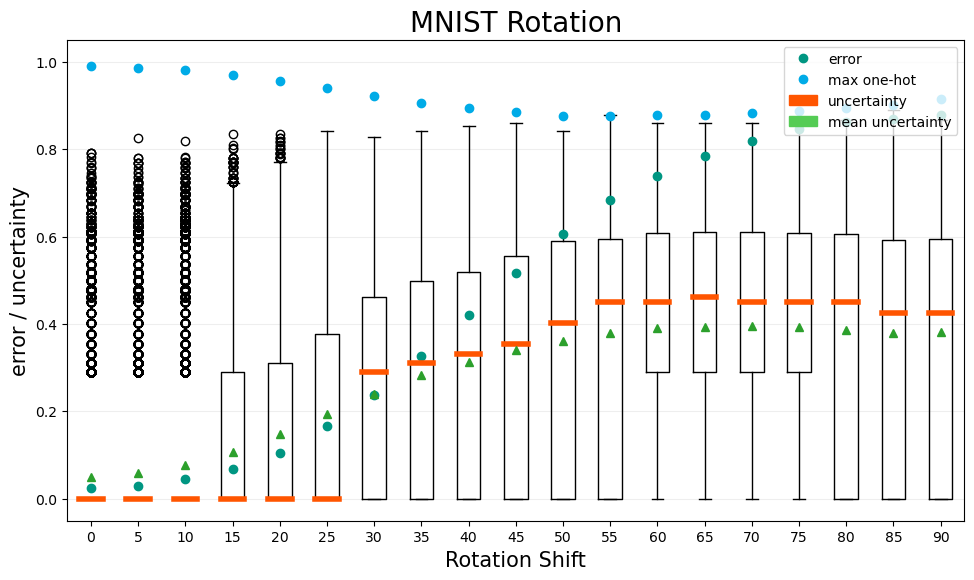

In [8]:
plot_mcd_results(ROTATIONS, mcd, errors, max_one_hot, "MNIST Rotation", "Rotation Shift")

Our proposed uncertainty metric provides a reliable performance estimation that reflects the model’s uncertainty, as evidenced by its strong correlation with the model’s error.

This finding is significant for systems under deployment, as this shows that the novel approach can provide a proxy for model performance without the need for ground truth labels at runtime. Furthermore, our proposed uncertainty estimation method reliably approximates the model’s prediction error, particularly on out-of-domain data.

### Leaving the Sandbox

Taking the method to the real world, another experiment we conducted was to use the metric on an image segmentation model. The metric is applied to every pixel of the predictions. This results in one uncertainty value per pixel (bottom video in the gif below). The gif below shows the input to the model at the top, the prediction in the middle and the uncertainty at the bottom. 

<img src="rain_cc_metric.gif" width="454" align="center">


We proposed a method for addressing the issue of unnoticed catastrophic deployment and domain shift in neural networks for semantic segmentation in autonomous driving. Our approach is based on the idea that deep learning-based perception for autonomous driving is uncertain and best represented as a probability distribution. 

Our defensive perception envelope encapsulates the neural network under deployment within an envelope based on the epistemic uncertainty estimation through the Monte Carlo Dropout approach. This approach does not require modification of the deployed neural network and has been shown to guarantee expected model performance. In addition, our defensive driving envelope has the capability to estimate a neural network’s performance, enabling monitoring and notification of entering domains of reduced neural network performance under deployment.

We invite you to build upon this sandbox, please make sure to cite the accompanying paper. We hope to be able to contribute to safety architectures in autonomous driving and AI systems in general. 